In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the preprocessed CSV
df = pd.read_csv('../data/citi_stock_data.csv', header=1, skiprows=[0])
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.rename(columns={df.columns[0]: 'Close_C'}, inplace=True)
df = df[['Close_C']]
df.head()

,Close_C
Date,
2019-01-01,44.022671
2019-01-08,46.650890
2019-01-15,49.967827
2019-01-22,50.545727
2019-01-29,50.711956


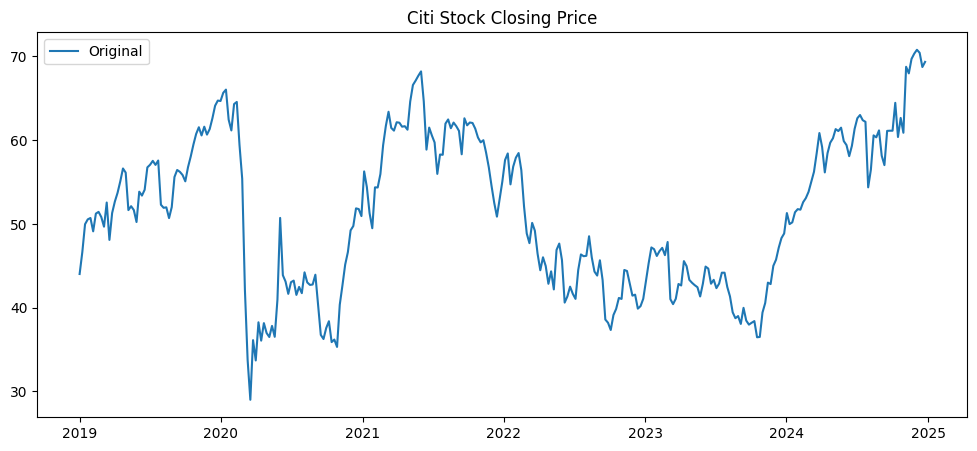

In [3]:
# Visualize original series
plt.figure(figsize=(12, 5))
plt.plot(df['Close_C'], label='Original')
plt.title('Citi Stock Closing Price')
plt.legend()
plt.show()

In [4]:
# Reformat data for Prophet
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Close_C': 'y'})

In [5]:
# Train-test split (same as ARIMA)
train_prophet = df_prophet[df_prophet['ds'] < '2024-01-01']
test_prophet = df_prophet[df_prophet['ds'] >= '2024-01-01']

In [6]:
# Fit Prophet model
model_prophet = Prophet()
model_prophet.fit(train_prophet)

22:44:50 - cmdstanpy - INFO - Chain [1] start processing
22:44:50 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Make future dataframe for the full period
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='W')
forecast = model_prophet.predict(future)

# Only keep forecast rows that match test dates
forecast_test = forecast[forecast['ds'].isin(test_prophet['ds'])]

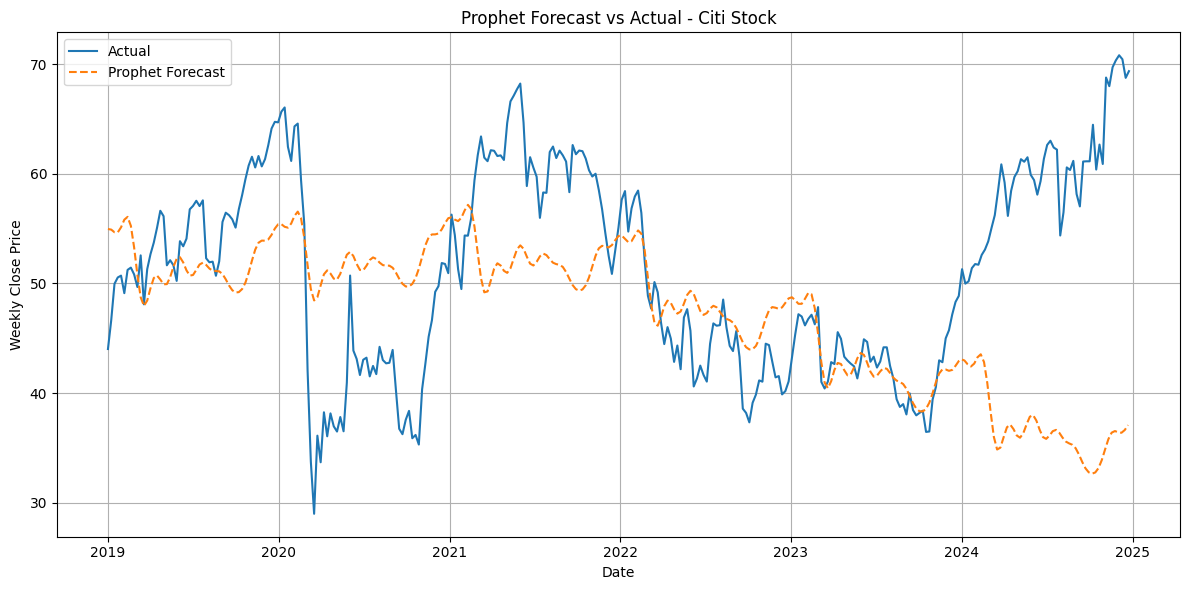

In [8]:
# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--')
plt.title('Prophet Forecast vs Actual - Citi Stock')
plt.xlabel('Date')
plt.ylabel('Weekly Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../visuals/prophet_forecast_vs_actual.png')
plt.show()

In [9]:
# Align both to week starts
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.to_period('W').dt.start_time
test_prophet['ds'] = pd.to_datetime(test_prophet['ds']).dt.to_period('W').dt.start_time

/var/folders/yt/553f2tq97psd1r3ctc7cfdxc0000gn/T/ipykernel_72435/3953211161.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prophet['ds'] = pd.to_datetime(test_prophet['ds']).dt.to_period('W').dt.start_time


In [10]:
# Merge forecast and actuals on date
merged = pd.merge(
    test_prophet[['ds', 'y']],
    forecast[['ds', 'yhat']],
    on='ds',
    how='inner'  # Ensures only matching dates
)

# Extract aligned values
y_true = merged['y']
y_pred = merged['yhat']

# Calculate error metrics
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mae_prophet = mean_absolute_error(y_true, y_pred)

print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")

Prophet RMSE: 24.08
Prophet MAE: 22.94
